## NLP Shakespeare 
Idea of the exercise is to find whether a deep network can create a poetry or not. We will train the model using Shakespeare Sonnet.    

#### First Mount the Drive 

In [35]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!pip3 install tensorflow==2.0.0-beta0

     |████████████████████████████████| 87.9MB 104kB/s 
     |████████████████████████████████| 501kB 48.6MB/s 
     |████████████████████████████████| 3.1MB 52.2MB/s 
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled tensorflow-1.15.0


#### Import Libraries 

In [36]:
import tensorflow as tf
print ("check tensorflow version: ", tf.__version__)

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku

import matplotlib.pyplot as plt
import numpy as np


check tensorflow version:  2.0.0-beta0


#### Read the sonnet file and create the corpus 
use tokenizer in the next step

In [37]:
sonnets = open('/content/gdrive/My Drive/Colab Notebooks/NLP_Week4/sonnets.txt').read()
corpus = sonnets.lower().split("\n") # split function is called on the line-break, so that every line of the sonnet is now individual elements of the corpus list.   
print ("corpus type: ", type(corpus))
print ("first few elements of corpus: ", corpus[5:10])

tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus) # creates the dictionary of the overall corpus, with key as word and value is the correpsonding token.  

total_words = len(tokenizer.word_index) + 1
print ("total number of words + unknown : ", total_words)

corpus type:  <class 'list'>
first few elements of corpus:  ["feed'st thy light'st flame with self-substantial fuel,", 'making a famine where abundance lies,', 'thyself thy foe, to thy sweet self too cruel.', "thou that art now the world's fresh ornament", 'and only herald to the gaudy spring,']
total number of words + unknown :  3211


#### Create the training data from the corpus
Here's a brief outline of how we can create list of n-gram sequence. 
1. First we iterate over each element of the corpus list, which is basically a single line of the sonnet. 
2. Use _texts_to_sequences_ method to create list of tokens that represent the words on the line. Note: _texts_to_sequences_ on ([line]) creates a list of list (ex: [[2, 3, 4,5]]), so, to access the list we need to use _texts_to_sequences_([line])[0]. 
3. Iterate over the list of tokens to create a number of n gram sequences. So the first two words will be one squence, first 3 another sequence and so on.. 
4. We append all the sequences to create a new list
5. Then we figure out the longest sentence of the corpus so that later we can pad our sequences.  
6. Now we pad all the sequences so that they are all of same lengths. Here we use pre padding. This is important because now our sequences will look like as [0 0 0 0 0 2 3], [0 0 0 0 2 3 4], [0 0 0 2 3 4 5] and so on.... With this it is now easy to create x(input) and y(output). Always the last element of the list will be the prediction and everything else will be features. 
7. Create features and labels by slicing the array. 
8. One hot encode the labels, here the number of classes will be the number of the words. So after the one hot encoding our y will be an array of length of number of words in the corpus, and the value that is set to 1 is the index of the label. that means [0 0 2 3 4 5 6], 6th element of y will be set to 1 and everything else will be zero.     

In [38]:
input_seq = []
for line in corpus:
  token_list = tokenizer.texts_to_sequences([line])[0]
  for x in range(1, len(token_list)):
    n_gram_seq = token_list[:x+1]
    input_seq.append(n_gram_seq)

max_seq_len = max([len(x) for x in input_seq])
input_seq = np.array(pad_sequences(input_seq, maxlen=max_seq_len, padding='pre'))
print ("check the shape of the input_seq: ", input_seq.shape) # two dimensional array
pred, label = input_seq[:, :-1], input_seq[:, -1]
label_one_hot = ku.to_categorical(label, num_classes=total_words)

print ("check the one hot encoded label shape: ", label_one_hot.shape) # perfect!

check the shape of the input_seq:  (15462, 11)
check the one hot encoded label shape:  (15462, 3211)


#### Build the Model 
The layers will be-- 
1. Embedding layer. 
2. Bi-directional LSTM
3. Dropout 
4. LSTM
5. Dense layer with number of nodes = total_words/2
6. Dense layer with number of nodes = total_words

In [39]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_seq_len - 1))
model.add(Bidirectional(LSTM(120, return_sequences='True')))
model.add(Dropout(0.3))
model.add(LSTM(100))
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(l=0.01)))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 10, 100)           321100    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 10, 240)           212160    
_________________________________________________________________
dropout_5 (Dropout)          (None, 10, 240)           0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 100)               136400    
_________________________________________________________________
dense_10 (Dense)             (None, 1605)              162105    
_________________________________________________________________
dense_11 (Dense)             (None, 3211)              5156866   
Total params: 5,988,631
Trainable params: 5,988,631
Non-trainable params: 0
____________________________________________

In [40]:
history = model.fit(pred, label_one_hot, epochs=120, verbose=2)

Train on 15462 samples
Epoch 1/120
15462/15462 - 56s - loss: 6.9149 - accuracy: 0.0206
Epoch 2/120
15462/15462 - 55s - loss: 6.4986 - accuracy: 0.0228
Epoch 3/120
15462/15462 - 55s - loss: 6.3769 - accuracy: 0.0266
Epoch 4/120
15462/15462 - 55s - loss: 6.2555 - accuracy: 0.0335
Epoch 5/120
15462/15462 - 55s - loss: 6.1689 - accuracy: 0.0364
Epoch 6/120
15462/15462 - 55s - loss: 6.0905 - accuracy: 0.0391
Epoch 7/120
15462/15462 - 55s - loss: 6.0127 - accuracy: 0.0424
Epoch 8/120
15462/15462 - 55s - loss: 5.9306 - accuracy: 0.0452
Epoch 9/120
15462/15462 - 54s - loss: 5.8302 - accuracy: 0.0500
Epoch 10/120
15462/15462 - 54s - loss: 5.7248 - accuracy: 0.0576
Epoch 11/120
15462/15462 - 55s - loss: 5.6139 - accuracy: 0.0627
Epoch 12/120
15462/15462 - 55s - loss: 5.5113 - accuracy: 0.0672
Epoch 13/120
15462/15462 - 54s - loss: 5.4018 - accuracy: 0.0717
Epoch 14/120
15462/15462 - 54s - loss: 5.2993 - accuracy: 0.0797
Epoch 15/120
15462/15462 - 54s - loss: 5.2023 - accuracy: 0.0853
Epoch 16/12

#### View Accuracy and Loss over Epochs

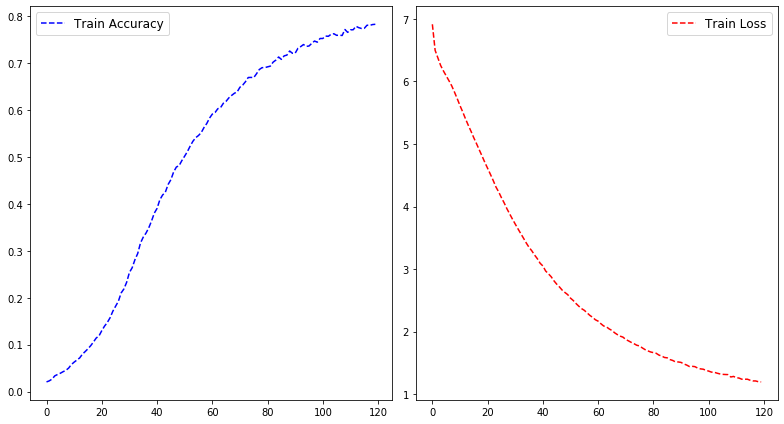

In [41]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

num_epochs = range(len(train_acc))

plt.figure(figsize=(11, 6))
plt.subplot(1, 2, 1)
plt.plot(num_epochs, train_acc, linestyle='--', label='Train Accuracy', color='blue')
plt.legend(fontsize=12)

plt.subplot(1, 2, 2)
plt.plot(num_epochs, train_loss, linestyle='--', label='Train Loss', color='red')
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

#### Create Our Own Poem 

In [44]:
seed_text = "Help me Lord, You are my light"
next_words = 50


for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_seq_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word



print("finalized prediction: ", seed_text)


finalized prediction:  Help me Lord, You are my light knew his speak had away alone doth dwell in pleasure thee aside aside long seen seen seen told days pain date light wind hearted decrease aside ' did lie anew to trust away long more hour their taste doth stand 'tis thee away new fangled sight and lie on your
